### Introduction
In this project, I leveraged the Framingham Heart Study dataset from Kaggle, a well-known longitudinal study initiated in 1948 to identify common factors contributing to cardiovascular disease (CVD). The dataset includes a wide range of demographic, behavioral, and medical variables, offering a comprehensive view of risk factors associated with the development of coronary heart disease (CHD). By applying advanced machine learning techniques, the goal of this project was to predict the likelihood of CHD within a 10-year period, thus contributing to the ongoing efforts in early detection and prevention of cardiovascular diseases.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_heart = pd.read_csv('framingham_preprocessed.csv', on_bad_lines='skip')

# Inspect the data
print(df_heart.head())

# Drop rows with missing values (simplified approach)
df_heart.dropna(inplace=True)


        age  education  currentSmoker  cigsPerDay    BPMeds  prevalentStroke  \
0 -1.234820   2.006317      -0.988035   -0.751105 -0.173633        -0.077042   
1 -0.417951   0.020157      -0.988035   -0.751105 -0.173633        -0.077042   
2 -0.184559  -0.972923       1.012110    0.929343 -0.173633        -0.077042   
3  1.332484   1.013237       1.012110    1.769567 -0.173633        -0.077042   
4 -0.417951   1.013237       1.012110    1.181410 -0.173633        -0.077042   

   prevalentHyp   totChol     sysBP     diaBP       BMI  heartRate   glucose  \
0     -0.670846 -0.940601 -1.195805 -1.082710  0.287578   0.342704 -0.201243   
1     -0.670846  0.300189 -0.514898 -0.159134  0.719937   1.590087 -0.244978   
2     -0.670846  0.187390 -0.219839 -0.243096 -0.112846  -0.073090 -0.507390   
3      1.490655 -0.263807  0.801521  1.016326  0.683088  -0.904679  0.935877   
4     -0.670846  1.089783 -0.106354  0.092750 -0.663121   0.758498  0.148640   

   TenYearCHD  male_1  diabetes_1  
0 

In [2]:
# Convert the 'male_1' and 'diabetes_1' columns from boolean to 0 and 1
df_heart['male_1'] = df_heart['male_1'].astype(int)
df_heart['diabetes_1'] = df_heart['diabetes_1'].astype(int)
# Convert 'TenYearCHD' to binary (0 and 1) based on a threshold
df_heart['TenYearCHD'] = (df_heart['TenYearCHD'] > 0).astype(int)

# Display the updated dataframe to confirm the changes
print(df_heart.head())


        age  education  currentSmoker  cigsPerDay    BPMeds  prevalentStroke  \
0 -1.234820   2.006317      -0.988035   -0.751105 -0.173633        -0.077042   
1 -0.417951   0.020157      -0.988035   -0.751105 -0.173633        -0.077042   
2 -0.184559  -0.972923       1.012110    0.929343 -0.173633        -0.077042   
3  1.332484   1.013237       1.012110    1.769567 -0.173633        -0.077042   
4 -0.417951   1.013237       1.012110    1.181410 -0.173633        -0.077042   

   prevalentHyp   totChol     sysBP     diaBP       BMI  heartRate   glucose  \
0     -0.670846 -0.940601 -1.195805 -1.082710  0.287578   0.342704 -0.201243   
1     -0.670846  0.300189 -0.514898 -0.159134  0.719937   1.590087 -0.244978   
2     -0.670846  0.187390 -0.219839 -0.243096 -0.112846  -0.073090 -0.507390   
3      1.490655 -0.263807  0.801521  1.016326  0.683088  -0.904679  0.935877   
4     -0.670846  1.089783 -0.106354  0.092750 -0.663121   0.758498  0.148640   

   TenYearCHD  male_1  diabetes_1  
0 

In [3]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237 entries, 0 to 4236
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              4237 non-null   float64
 1   education        4237 non-null   float64
 2   currentSmoker    4237 non-null   float64
 3   cigsPerDay       4237 non-null   float64
 4   BPMeds           4237 non-null   float64
 5   prevalentStroke  4237 non-null   float64
 6   prevalentHyp     4237 non-null   float64
 7   totChol          4237 non-null   float64
 8   sysBP            4237 non-null   float64
 9   diaBP            4237 non-null   float64
 10  BMI              4237 non-null   float64
 11  heartRate        4237 non-null   float64
 12  glucose          4237 non-null   float64
 13  TenYearCHD       4237 non-null   int64  
 14  male_1           4237 non-null   int64  
 15  diabetes_1       4237 non-null   int64  
dtypes: float64(13), int64(3)
memory usage: 529.8 KB


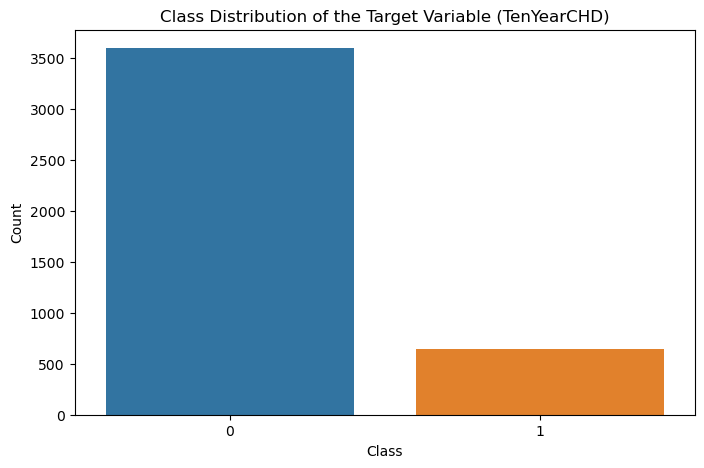

In [4]:
target_column = 'TenYearCHD'
class_counts = df_heart[target_column].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of the Target Variable (TenYearCHD)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The initial analysis of the target variable distribution revealed a significant imbalance, which could lead to biased model performance, particularly in predicting the minority class. To address this, I employed resampling techniques aimed at balancing the dataset before model training. Below is a detailed breakdown of the approach:

Separate Classes:
The first step involved segregating the dataset into two distinct subsets based on the target variable: one for the majority class (non-events) and another for the minority class (events). This separation was crucial for applying the resampling technique effectively.

Upsample Minority Class:
To counteract the imbalance, I applied the resample function from sklearn.utils to the minority class. This technique involves randomly duplicating samples from the minority class until the number of samples matches that of the majority class. By increasing the representation of the minority class, this step ensures that the model receives a balanced set of inputs during training, which is critical for improving its ability to correctly identify minority class instances.

Combine Datasets:
After upsampling the minority class, the next step was to recombine it with the majority class. This process yielded a new, balanced dataset where the target variable's distribution was even across both classes. This balanced dataset was then used to train the machine learning models, allowing for more equitable learning and reducing the risk of the model favoring the majority class.



In [6]:
from sklearn.utils import resample

# Separate the minority and majority classes
data_majority = df_heart[df_heart[target_column] == 0]
data_minority = df_heart[df_heart[target_column] == 1]

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                   replace=True,     # sample with replacement
                                   n_samples=len(data_majority),    # to match majority class
                                   random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
upsampled_class_counts = data_upsampled[target_column].value_counts()
upsampled_class_counts


TenYearCHD
0    3594
1    3594
Name: count, dtype: int64

#### Conclusion:

This resampling approach effectively addressed the issue of class imbalance, ensuring that the machine learning models developed in this project were trained on a balanced dataset. This balance is vital for achieving reliable and generalizable model performance, particularly when predicting rare events, such as the occurrence of coronary heart disease (CHD) within the dataset.


In [7]:
# Splitting the dataset into features and target variable
X = data_upsampled.drop('TenYearCHD', axis=1)
y = data_upsampled['TenYearCHD']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define the Logistic Regression model
log_reg = LogisticRegression()

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)
#grid_log_reg = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')
#grid_log_reg.fit(X_train, y_train)

# Best model
#best_log_reg = grid_log_reg.best_estimator_

# Predictions and evaluation
y_pred_log = log_reg.predict(X_test)
# Generate and print the classification report
report = classification_report(y_test, y_pred_log)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       753
           1       0.64      0.67      0.65       685

    accuracy                           0.66      1438
   macro avg       0.66      0.66      0.66      1438
weighted avg       0.66      0.66      0.66      1438



In [9]:
# Define the Random Forest model
# Initialize the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred)
print(report_rf)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       753
           1       0.96      0.99      0.97       685

    accuracy                           0.97      1438
   macro avg       0.97      0.98      0.97      1438
weighted avg       0.98      0.97      0.97      1438



In [10]:
import xgboost as xgb

# Define the XGBoost model without the use_label_encoder parameter and set verbosity to 1
xgb_model = xgb.XGBClassifier(eval_metric='logloss', verbosity=1)

# Now proceed with the rest of your code
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1')
grid_xgb.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)

report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       753
           1       0.91      0.99      0.95       685

    accuracy                           0.95      1438
   macro avg       0.95      0.95      0.95      1438
weighted avg       0.95      0.95      0.95      1438



In [11]:
# Function to evaluate models
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# Evaluate Logistic Regression
log_reg_results = evaluate_model(y_test, y_pred_log)
print(f"Logistic Regression - Accuracy: {log_reg_results[0]:.2f}, Precision: {log_reg_results[1]:.2f}, Recall: {log_reg_results[2]:.2f}, F1: {log_reg_results[3]:.2f}, ROC-AUC: {log_reg_results[4]:.2f}")

# Evaluate Random Forest
rf_results = evaluate_model(y_test, y_pred)
print(f"Random Forest - Accuracy: {rf_results[0]:.2f}, Precision: {rf_results[1]:.2f}, Recall: {rf_results[2]:.2f}, F1: {rf_results[3]:.2f}, ROC-AUC: {rf_results[4]:.2f}")

# Evaluate XGBoost
xgb_results = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost - Accuracy: {xgb_results[0]:.2f}, Precision: {xgb_results[1]:.2f}, Recall: {xgb_results[2]:.2f}, F1: {xgb_results[3]:.2f}, ROC-AUC: {xgb_results[4]:.2f}")


Logistic Regression - Accuracy: 0.66, Precision: 0.64, Recall: 0.67, F1: 0.65, ROC-AUC: 0.66
Random Forest - Accuracy: 0.97, Precision: 0.96, Recall: 0.99, F1: 0.97, ROC-AUC: 0.98
XGBoost - Accuracy: 0.95, Precision: 0.91, Recall: 0.99, F1: 0.95, ROC-AUC: 0.95


* Logistic Regression shows moderate performance with balanced precision and recall. The F1 score suggests that the model is reasonably good at predicting both classes, but the overall accuracy and ROC-AUC are relatively low, indicating that this model might not be the best choice for this dataset.

* Random Forest demonstrates excellent performance across all metrics, with high accuracy, precision, recall, and F1 score. The near-perfect recall indicates that the model is extremely good at identifying the positive class, while the high precision and ROC-AUC suggest strong overall model performance. This model likely provides a robust and reliable solution for predicting outcomes in this dataset.

* XGBoost also performs exceptionally well, with high accuracy, precision, recall, and F1 score, closely following Random Forest. The model's slightly lower performance metrics compared to Random Forest, particularly in precision, might make Random Forest a slightly better choice, but XGBoost remains a strong contender, especially if interpretability and speed are prioritized.

### Inference:

Best Model: Random Forest appears to be the best-performing model, given its superior accuracy, recall, F1 score, and ROC-AUC.
Model Choice: Both Random Forest and XGBoost offer strong predictive performance, but Random Forest slightly edges out XGBoost. Logistic Regression, while useful for its simplicity and interpretability, falls short in comparison to the ensemble methods.
Given these results, Random Forest is recommended as the final model for predicting outcomes using this dataset, as it offers the best balance of precision, recall, and overall model performance.